# Author Ranking
Creating a ranking of the authors who published the most to CIAA
###### Nils Dyck, 10.05.2023

In [12]:
import pandas as pd

df = pd.read_csv('../data/cleaned/CIAA-CIAA.csv', sep=';')
df = df.loc[df['Year']<2022]
everyone = df['Author-URL'].to_list()
authors = set(everyone)

dfm = pd.read_csv('../data/cleaned/CIAA-CIAA_m2.csv', sep=';')
dfm = dfm.loc[dfm['Year']<2022]

# df = pd.read_csv('../data/cleaned/DATASET2.csv', sep=';')
# df = df.loc[df['Year']<2022]
# everyone = df['Author-URL'].to_list()
# authors = set(everyone)

Number of papers.

In [13]:
def get_name(url):
    name = df.loc[df['Author-URL']==url]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')
    return name

paper_ranking = {}
fractional_ranking = {}
co_worker_ranking = {}
collaboration_weight = {}
collaboration_weight_urls = {}
for author in authors:
    papers = everyone.count(author)
    name = df.loc[df['Author-URL']==author]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')    
    paper_ranking[name] = papers
    papers = df.loc[df['Author-URL']==author]
    co_authors = papers['Co-Author-URLs'].to_list()
    fraction = 0
    co_workers = []
    for l in co_authors:
        l = l.replace('[','').replace(']','').replace('"','').replace("'",'') 
        l = l.split(', ')
        for i in l:
            if i != '':
                if collaboration_weight.get((name,get_name(i))):
                    collaboration_weight[(name,get_name(i))] += 1
                    collaboration_weight_urls[(author,i)] += 1
                else:
                    collaboration_weight[(name,get_name(i))] = 1
                    collaboration_weight_urls[(author,i)] = 1
        fraction += (1/(len(l)+1))
        co_workers += l
    co_workers = set(co_workers)
    co_workers = [entry for entry in co_workers if entry != '']
    co_worker_ranking[name] = len(co_workers)
    fractional_ranking[name] = fraction

paper_ranking_sorted = dict(sorted(paper_ranking.items(), key=lambda item: item[1], reverse=True))
fractional_ranking_sorted = dict(sorted(fractional_ranking.items(), key=lambda item: item[1], reverse=True))
co_worker_ranking_sorted = dict(sorted(co_worker_ranking.items(), key=lambda item: item[1], reverse=True))
collaboration_weight_sorted = dict(sorted(collaboration_weight.items(), key=lambda item: item[1], reverse=True))

#delete duplicates in collaboration weight
keys = list(collaboration_weight_sorted.keys())
control = set(keys)
for key in keys:
    if set(key) in control:
        del collaboration_weight_sorted[(key[1],key[0])]
        control.remove(set(key))

top10_papers = list(paper_ranking_sorted.items())[:10]
top10_fractional = list(fractional_ranking_sorted.items())[:10]
top10_co_workers = list(co_worker_ranking_sorted.items())[:10]
top10_collaboration_weights = list(collaboration_weight_sorted.items())[:10]

In [14]:
# calculate newman collaboration weight
collabs = set(list(collaboration_weight_urls.keys()))
newman_collab = {}
for entry in collabs:
    papers = dfm.loc[dfm['Author']==entry[0]]
    papers_together = papers.loc[papers['Co-Authors'].apply(lambda x: entry[1] in x)]
    no_authors = papers_together['No Authors'].to_list()
    erg = 0
    for n in no_authors:
        erg += (1/(n-1))
    newman_collab[get_name(entry[0]),get_name(entry[1])] = erg

#remove duplicates from dictionary
newman_collab_sorted = {}
key_set = set(newman_collab.keys())

for key in key_set:
    newman_collab_sorted[key] = newman_collab[key]
newman_collab_modified = {}
for key, value in newman_collab_sorted.items():
    modified_key = tuple(element.replace(",", "").replace("'", "").replace("(", "").replace(")", "") for element in key)
    newman_collab_modified[modified_key] = value

newman_collab_sorted = {(a, b): value for (a, b), value in newman_collab_modified.items() if a <= b}
newman_collab_modified = {}
for key, value in newman_collab_sorted.items():
    modified_key = tuple(element.replace(",", "").replace("'", "").replace("(", "").replace(")", "") for element in key)
    newman_collab_modified[modified_key] = value
top10_newman_collab = sorted(newman_collab_modified.items(), key=lambda item: item[1], reverse=True)[:10]
top10_newman_collab

[(('Markus Holzer', 'Martin Kutrib'), 6.0),
 (('Cyril Allauzen', 'Mehryar Mohri'), 4.25),
 (('Andreas Malcher', 'Martin Kutrib'), 4.25),
 (('Jacques Sakarovitch', 'Sylvain Lombardy'), 4.166666666666667),
 (('Nelma Moreira', 'Rogério Reis'), 3.75),
 (('Martin Kutrib', 'Matthias Wendlandt'), 3.75),
 (('Kai Salomaa', 'Sheng Yu'), 3.6666666666666665),
 (('Sang-Ki Ko', 'Yo-Sub Han'), 3.5),
 (('Djelloul Ziadi', 'Jean-Marc Champarnaud'), 2.833333333333333),
 (('Cyril Allauzen', 'Michael D. Riley'), 2.75)]

In [15]:
from tabulate import tabulate

headers = ['number of papers']
table1 = tabulate(top10_papers, headers, tablefmt='latex')
#print(table1)

headers = ['fractional no. of papers']
table2 = tabulate(top10_fractional, headers, tablefmt='latex')
#print(table2)

headers = ['number of co-workers']
table3 = tabulate(top10_co_workers, headers, tablefmt='latex')
#print(table1)

headers = ['collaboration weight']
table4 = tabulate(top10_collaboration_weights, headers, tablefmt='latex')
#print(table4)

headers = ['collaboration weight (Newman)']
table5 = tabulate(top10_newman_collab, headers, tablefmt='latex')
print(table5)

\begin{tabular}{lr}
\hline
                                             &   collaboration weight (Newman) \\
\hline
 ('Markus Holzer', 'Martin Kutrib')          &                         6       \\
 ('Cyril Allauzen', 'Mehryar Mohri')         &                         4.25    \\
 ('Andreas Malcher', 'Martin Kutrib')        &                         4.25    \\
 ('Jacques Sakarovitch', 'Sylvain Lombardy') &                         4.16667 \\
 ('Nelma Moreira', 'Rogério Reis')           &                         3.75    \\
 ('Martin Kutrib', 'Matthias Wendlandt')     &                         3.75    \\
 ('Kai Salomaa', 'Sheng Yu')                 &                         3.66667 \\
 ('Sang-Ki Ko', 'Yo-Sub Han')                &                         3.5     \\
 ('Djelloul Ziadi', 'Jean-Marc Champarnaud') &                         2.83333 \\
 ('Cyril Allauzen', 'Michael D. Riley')      &                         2.75    \\
\hline
\end{tabular}


In [16]:
fractional_ranking = {}
for author in authors:
    count = dfm['No Authors'].loc[dfm['Author']==author].to_list()
    name = df.loc[df['Author-URL']==author]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')
    res = 0
    for i in count:
        res += 1/i
    fractional_ranking[name] = res
fractional_ranking_sorted = dict(sorted(fractional_ranking.items(), key=lambda item: item[1], reverse=True))
top10_fractional = list(fractional_ranking_sorted.items())[:11]
headers = ['fractional no. of papers']
table2 = tabulate(top10_fractional, headers, tablefmt='latex')
print(table2)


\begin{tabular}{lr}
\hline
                       &   fractional no. of papers \\
\hline
 A. N. Trahtman        &                   10       \\
 Andreas Maletti       &                    9.08333 \\
 Bruce W. Watson       &                    9       \\
 Martin Kutrib         &                    8.2     \\
 Oscar H. Ibarra       &                    7.58333 \\
 Markus Holzer         &                    7       \\
 Mehryar Mohri         &                    6.86667 \\
 Jean-Marc Champarnaud &                    6.81667 \\
 Borivoj Melichar      &                    6.23333 \\
 Johanna Björklund     &                    6       \\
 Kai Salomaa           &                    6       \\
\hline
\end{tabular}


In [17]:
print(fractional_ranking_sorted['Bruce W. Watson'])

9.0


Mean collaborators per author.

In [18]:
import statistics

mean = statistics.mean(co_worker_ranking.values())
mean

2.567342073897497

### Collaboration Power Law

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


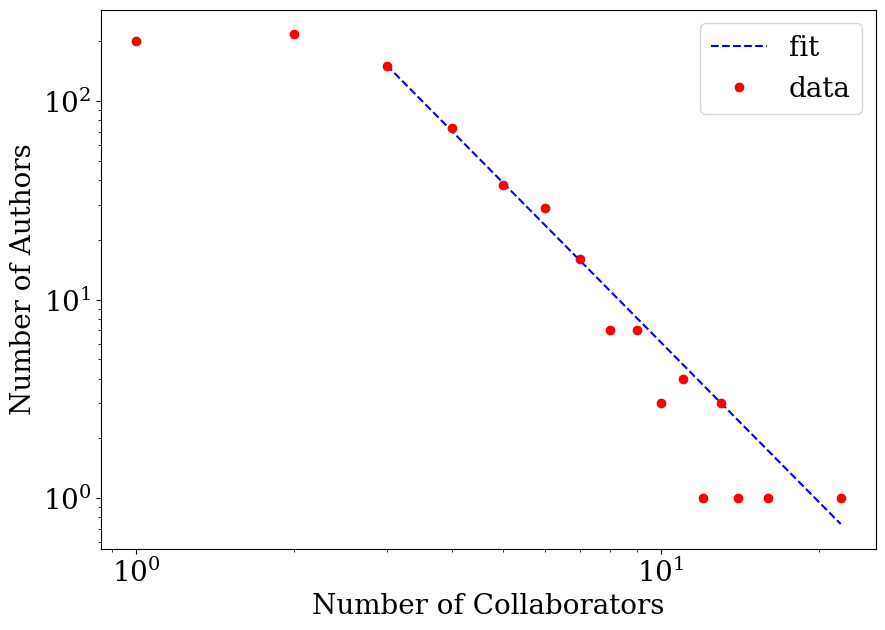

In [19]:
import matplotlib.pyplot as plt, numpy as np, math
from scipy.optimize import curve_fit

plt.figure(figsize=(10,7))
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=20)

# Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Initiate data
x = np.linspace(1,22,22)
y = [list(co_worker_ranking.values()).count(i) for i in range(1,23)]
x_fit = x[2:]
y_fit = y[2:]

# Fit the power-law function to the data
popt, pcov = curve_fit(power_law, x_fit, y_fit)

# Plot the fitted power-law curve
y_fit = power_law(x_fit, *popt)
plt.loglog(x_fit, y_fit, '--b', label='fit')

# Plot the data on a log-log scale
plt.loglog(x, y, 'or', label='data')

# Add labels and legend
plt.xlabel('Number of Collaborators')
plt.ylabel('Number of Authors')
plt.legend()
#plt.axis((0.9e0,0.3e2,0.75e0,1e3))

plt.savefig('../../Figures/ciaa_collab_power-law.png', bbox_inches='tight')

## CIAA-ALL

In [20]:
df = pd.read_csv('../data/cleaned/DATASET3.csv', sep=';')
df = df.loc[df['Year']<2022]
everyone = df['Author-URL'].to_list()
authors = set(everyone)

paper_ranking = {}
fractional_ranking = {}
co_worker_ranking = {}
for author in authors:
    papers = everyone.count(author)
    name = df.loc[df['Author-URL']==author]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')    
    paper_ranking[name] = papers
    papers = df.loc[df['Author-URL']==author]
    co_authors = papers['Co-Author-URLs'].to_list()
    fraction = 0
    co_workers = []
    for l in co_authors:
        l = l.replace('[','').replace(']','').replace('"','').replace("'",'') 
        l = l.split(', ')
        fraction += (1/(len(l)+1))
        co_workers += l
    co_workers = set(co_workers)
    co_workers = [entry for entry in co_workers if entry != '']
    co_worker_ranking[name] = len(co_workers)
    fractional_ranking[name] = fraction

paper_ranking_sorted = dict(sorted(paper_ranking.items(), key=lambda item: item[1], reverse=True))
fractional_ranking_sorted = dict(sorted(fractional_ranking.items(), key=lambda item: item[1], reverse=True))
co_worker_ranking_sorted = dict(sorted(co_worker_ranking.items(), key=lambda item: item[1], reverse=True))

top10_papers = list(paper_ranking_sorted.items())[:10]
top10_fractional = list(fractional_ranking_sorted.items())[:10]
top10_co_workers =list(co_worker_ranking_sorted.items())[:10]
top10_co_workers

[('Cheng Li', 953),
 ('Alois C. Knoll', 849),
 ('Fei Xie', 527),
 ('Václav Snásel', 410),
 ('Xiaoyu Song', 372),
 ('Axel Legay', 364),
 ('Madhav V. Marathe', 362),
 ('Yong Sun', 349),
 ('Moshe Y. Vardi', 342),
 ('Kim Guldstrand Larsen', 339)]

In [21]:
from tabulate import tabulate

headers = ['number of papers']
table1 = tabulate(top10_papers, headers, tablefmt='latex')
#print(table1)

headers = ['fractional no. of papers']
table2 = tabulate(top10_fractional, headers, tablefmt='latex')
#print(table2)

headers = ['number of co-workers']
table3 = tabulate(top10_co_workers, headers, tablefmt='latex')
print(table1)

\begin{tabular}{lr}
\hline
                       &   number of papers \\
\hline
 Moshe Y. Vardi        &                720 \\
 Alois C. Knoll        &                700 \\
 Grzegorz Rozenberg    &                614 \\
 Václav Snásel         &                604 \\
 Gonzalo Navarro       &                578 \\
 Thomas A. Henzinger   &                527 \\
 B. Sundar Rajan       &                500 \\
 Kim Guldstrand Larsen &                499 \\
 Axel Legay            &                437 \\
 Oscar H. Ibarra       &                415 \\
\hline
\end{tabular}


In [22]:
mean = statistics.mean(co_worker_ranking.values())
mean

45.106078665077476